In [4]:
import pandas as pd
import os

import numpy as np

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [5]:

ecb_with_sentiment = pd.read_csv('./ecb_with_sentiment_bert.csv')
ecb_with_sentiment.head()

ecb_with_sentiment=ecb_with_sentiment.drop(columns=["contents"])
# ecb_with_sentiment = ecb_with_sentiment.loc[ecb_with_sentiment.subtitle.str.contains("\sMember\s"),:]

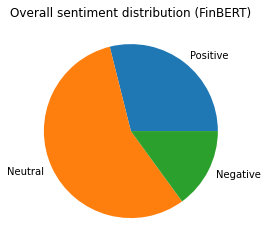

0
0.167935449335807
0.9


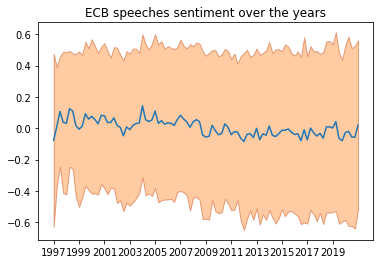

In [7]:

from scipy.ndimage.filters import gaussian_filter1d
# threshold_neutral = 0.6

#0.5 0.5 (no shift mean)
#0.6 0.6 (no shift mean)
threshold_significance = 0
threshold_mean_significance = 0
threshold_significance_fss = 0

for threshold_neutral in np.linspace(0.9,1,1):
    def remove_neutral(pos, neu, neg):
        pos = np.fromstring(pos[1:-1],sep=' ')
        neu = np.fromstring(neu[1:-1],sep=' ')
        neg = np.fromstring(neg[1:-1],sep=' ')
        combined = np.array([pos,neu,neg]).T #(num_of_sent,3)
        filtered = combined[neu<threshold_neutral]
        res = (filtered.T[0]-filtered.T[2]) 
        res = res[np.abs(res)>threshold_significance]
        return res

    def fss(pos, neg):
        pos = np.fromstring(pos[1:-1],sep=' ')
        neg = np.fromstring(neg[1:-1],sep=' ')
        combined = pos - neg
        filtered = combined[np.abs(combined)<threshold_significance_fss]
        filtered = (np.heaviside(filtered, 0) -0.5) *2
        if len(filtered) == 0:
            return 0
        else:
            return filtered.mean()

    def get_mean(arry):
        arry = np.fromstring(arry[1:-1],sep=' ')
        return np.mean(arry)

    ecb_with_sentiment['m_pos'] = ecb_with_sentiment.apply(lambda row: get_mean(row['pos_np']),axis=1)
    ecb_with_sentiment['m_neu'] = ecb_with_sentiment.apply(lambda row: get_mean(row['neu_np']),axis=1)
    ecb_with_sentiment['m_neg'] = ecb_with_sentiment.apply(lambda row: get_mean(row['neg_np']),axis=1)

    sentiment = ['Positive', 'Neutral', 'Negative']
    data = [ecb_with_sentiment['m_pos'].mean(), ecb_with_sentiment['m_neu'].mean(),ecb_with_sentiment['m_neg'].mean()]
    fig = plt.figure()
    plt.pie(data,labels=sentiment)
    plt.title("Overall sentiment distribution (FinBERT)")
    plt.show()

    ecb_with_sentiment['filtered'] = ecb_with_sentiment.apply(lambda row: remove_neutral(row['pos_np'],row['neu_np'],row['neg_np']),axis=1)

    ecb_with_sentiment['filtered_mean'] = ecb_with_sentiment.apply(lambda row: row['filtered'].mean(),axis=1)

    ecb_with_sentiment['filtered_std'] = ecb_with_sentiment.apply(lambda row: row['filtered'].std(),axis=1)

    ecb_with_sentiment['fss'] = ecb_with_sentiment.apply(lambda row: fss(row['pos_np'], row['neg_np']),axis=1)


    old = len(ecb_with_sentiment)
    ecb_with_sentiment_new = ecb_with_sentiment[np.abs(ecb_with_sentiment.filtered_mean) > threshold_mean_significance]
    new = len(ecb_with_sentiment_new)
    print(old-new)

    # for each time interval (quarterly)
    #    check speech overal sentiment
    #    plot graph
    
    # quarters = ["({0})".format(i) for i in range(1,13)]
    quarters = ["(1|2|3)","(4|5|6)", "(7|8|9)","(10|11|12)"]
    # quarters = ["(1|2|3|4|5|6|7|8|9|10|11|12)"]
    # quarters = ["(1|2|3|4|5|6)","(7|8|9|10|11|12)"]

    col = ["year","quarter","mean","std",] # "fss_mean", "fss_std", "pos_mean", "pos_std", "neg_mean","neg_std"])

    quarterly_data = pd.DataFrame(columns = col) 


    for year in range(1997,2022):
        for index, quarter in enumerate(quarters):
            data = ecb_with_sentiment_new.loc[ecb_with_sentiment['date'].str.contains(str(year) + '-0?' + quarter + '-'), :]
            # assume sample mean (neglect difference in datapoints)
            temp_data = pd.DataFrame([[year, index + 1, data['filtered_mean'].mean(), (data['filtered_std']**2).mean()**0.5]],columns = col)
        
            quarterly_data = quarterly_data.append(temp_data, ignore_index = True)

    quarterly_data.to_csv('./ecb_sentiment_quarterly_bert.csv')


    year = [[ year + index/4 for index in range (0, 4) ]for year in range(1997,2022)]
    year = [item for sublist in year for item in sublist]
    # year = [ year for year in range(1997,2022)]
    mean = quarterly_data['mean'].to_numpy()
        
    mean = gaussian_filter1d(mean, sigma=0.3)
  
    shift = np.nan_to_num(mean).mean()

    print(shift)
    # mean = mean - shift

    std = quarterly_data['std'].to_numpy()
        
    std = gaussian_filter1d(std, sigma=0.3) 
    # fss_mean = quarterly_data['fss_mean'].to_numpy()
    # fss_std = quarterly_data['fss_std'].to_numpy()
    # pos_mean = quarterly_data['pos_mean'].to_numpy()
    # pos_std = quarterly_data['pos_std'].to_numpy()
    # neg_mean = quarterly_data['neg_mean'].to_numpy()
    # neg_std = quarterly_data['neg_std'].to_numpy()

    fig = plt.figure()


    # import scipy.signal as signal

    # sos = signal.butter(536, 35, 'lp', fs=1000, output='sos')
    # filtered = signal.sosfiltfilt(sos, mean)

    x = year
    y = mean * 1
    yerr = std
    
    # plt.errorbar(x, y, yerr = yerr)
    plt.plot(x,y)

    plt.fill_between(x, y-yerr, y+yerr,
        alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    
    plt.xticks(np.arange(1997, 2021, 2))
    # plt.xlim(2000,2019)
    plt.title('ECB speeches sentiment over the years')
    print(threshold_neutral)
    plt.pause(0.1)
plt.show()
